## Edge signed graph problem

## Formulation

Let $G = (V,E,s)$ be a signed graph where $k \in \mathbb{N}$ and $1 \leq k \leq n$.

An edge $e \in E$ is called negative if $s(e) = −1$ and positive if $s(e) = +1$. 

Let $E^{-}$ and $E^{+}$ denote, respectively, the sets of negative and positive edges in a signed graph.

Let $K$ the sets of partition.

For a vertex set $S \subseteq V$ , let $E[S] = \{ (u,v) \in E \ | \ u,v \in S \}$ denote the subset of edges induced by $S$.

Let $S_i$ the partition $i$ of the $G$ where $i \in K = \{ 1,2, \ldots, k \}$.

A signed graph $G=(V,E,s)$ is $k$-balanced if $V$ can be partitioned into $S_1, S_2 , \ldots , S_l$ , with $l \leq k$, where $\cup_{i=1}^{l} E[S_i] = E^{+}$.

$
x_{vi} = 
\begin{cases}
1, & \text{ if } v \in S_i, \; \forall v \in V,\forall i \in K \\ 
0, & \text{otherwise}. 
\end{cases} 
$

$
y_{uv} = 
\begin{cases}
1, & \text{ if } (u,v) \text{ is removed}, \; \forall (u,v) \in E \\
0, & \text{ otherwise.} 
\end{cases} 
$

$$
\begin{align}
\min \quad & \sum\limits_{uv \in E} y_{uv} & \\
\text{s.t} \quad & \sum_{i \in [k]} x_{vi} \geq 1 & \forall v \in V  \\
& x_{ui} + x_{vi} \leq 1 + y_{uv} & \forall uv \in E^{-}, \forall i \in K \\
& x_{ui} \geq x_{vi} - y_{uv} & \forall uv \in E^{+}, \forall i \in K \\
& x_{vi} \geq x_{ui} - y_{uv} & \forall uv \in E^{+}, \forall i \in K \\
& x_{vi} \in \{0,1\} & \forall v \in V, \forall i \in K \\
& y_{vu} \in \{0,1\} & \forall uv \in E 
\end{align}
$$

## New inequalite

$
x_{ui} + x_{vj} \leq 1 + y_{uv}, \;  \forall uv \in E^{+}, \; \forall i,j \in K, \; i \not= j \\
$

In [205]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp

In [206]:
def edgesEN(G):
    EP = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    EN = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0]

    return EP, EN

In [207]:
# define tuple (vertice,partition)
def setVK(G,k):
    nodes = G.nodes()
    vk = []
    for u in nodes:
        for v in range(k):
            a = (u,v)
            vk.append(a)

    return vk

In [208]:
def read_instance(instance):
    with open(instance, 'r') as file: 
        lines = file.readlines()

    lines = [a.strip() for a in lines]

    values = lines[0].split()
    n, m = int(values[0]), int(values[1])

    #print("n =", n)
    #print("m =", m)

    G = nx.Graph()

    for u in range(n):
        G.add_node(u)

    for e in range(1,m+1):
        values = lines[e].split()
        u, v, val = int(values[0]), int(values[1]), int(values[2])
        G.add_edge(u, v, weight=val)

    return G


In [209]:
def plotGraph(G, pos):
    plt.figure(figsize=(25, 20))
    nx.draw_networkx(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [291]:
def position(G):
    #seed = 20532
    pos = nx.spring_layout(G)
    #pos=nx.random_layout(G)
    #pos=nx.circular_layout(G)
    #pos=nx.spectral_layout(G)
    #pos=nx.spiral_layout(G)
    #pos = nx.spring_layout(G, seed=seed)

    return pos

In [ ]:
def edge1_formulation(G, k, VK, EP, EN, method):

    nodes = G.nodes()
    edges = G.edges()
    K = range(k)
    
    #method = "mip" # mip or lp

    #modelnx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    model = gp.Model()

    # silent/verbose mode
    model.Params.OutputFlag = 0

    # variables
    if method == "mip":
        y = model.addVars(edges, vtype=gp.GRB.BINARY, name="y")
        #y = model.addVars(edges, lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="y")

        x = model.addVars(VK, vtype=gp.GRB.BINARY, name="x")

    model.update()

    #objective function
    obj = 0
    for e in edges:
        obj += y[e]
         
    model.setObjective(obj, gp.GRB.MINIMIZE)

    # constraints
 
    for v in nodes:
        constr = 0
        for i in K:
            constr += x[(v,i)] 
        model.addConstr(constr == 1.0, "constr2")

    for e in EN:
        for i in K:
            model.addConstr(x[(e[0],i)] + x[(e[1],i)] <= 1 + y[(e[0],e[1])], "constr3")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[0],i)] >= x[(e[1],i)] - y[(e[0],e[1])], "constr4")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[1],i)] >= x[(e[0],i)] - y[(e[0],e[1])], "constr5")

    if method != "mip":
        for v in model.getVars():
            v.setAttr('vtype', 'C')

    #model.write("edge_model.lp")
    
    model.optimize()
         
    tmp = 0
    if model.status == gp.GRB.OPTIMAL:
        tmp = 1
 
    objval = model.objVal
    runtime = model.Runtime
    status = tmp
    if method == "mip":
        objbound = model.objBound
        mipgap = model.MIPGap
        nodecount = model.NodeCount

    xval = {}
    for v in VK:
        xval[v] = x[v].x

    yval = {}
    for e in edges:
        yval[e] = y[e].x

    Ex = []
    for key, value in xval.items():
        if value > 0.5:
            Ex.append(key)

    Ey = []
    for key, value in yval.items():
        if value > 0.5:
            Ey.append(key)

    model.dispose()

    return objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey

In [313]:
def edge2_formulation(G, k, VK, EP, EN, method):

    nodes = G.nodes()
    edges = G.edges()
    K = range(k)
    
    #modelnx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    model = gp.Model()

    # silent/verbose mode
    model.Params.OutputFlag = 0

    # variables
    if method == "mip":
        y = model.addVars(edges, vtype=gp.GRB.BINARY, name="y")
        #y = model.addVars(edges, lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="y")

        x = model.addVars(VK, vtype=gp.GRB.BINARY, name="x")

    model.update()

    #objective function
    obj = 0
    for e in edges:
        obj += y[e]
         
    model.setObjective(obj, gp.GRB.MINIMIZE)

    # constraints
 
    for v in nodes:
        constr = 0
        for i in K:
            constr += x[(v,i)] 
        model.addConstr(constr == 1.0, "constr2")

    for e in EN:
        for i in K:
            model.addConstr(x[(e[0],i)] + x[(e[1],i)] <= 1 + y[(e[0],e[1])], "constr3")

    #for e in EP:
    #    for i in K:
    #        model.addConstr(x[(e[0],i)] >= x[(e[1],i)] - y[(e[0],e[1])], "constr4")

    #for e in EP:
    #    for i in K:
    #        model.addConstr(x[(e[1],i)] >= x[(e[0],i)] - y[(e[0],e[1])], "constr5")

    for e in EP:
        for i in K:
            for j in K: 
                if i != j:
                    model.addConstr(x[(e[0],i)] + x[(e[1],j)] <= 1 + y[(e[0],e[1])], "constr6")

    if method != "mip":
        for v in model.getVars():
            v.setAttr('vtype', 'C')


    #model.write("edge_model.lp")
    
    model.optimize()
         
    tmp = 0
    if model.status == gp.GRB.OPTIMAL:
        tmp = 1
 
    objval = model.objVal
    runtime = model.Runtime
    status = tmp
    if method == "mip":
        objbound = model.objBound
        mipgap = model.MIPGap
        nodecount = model.NodeCount

    xval = {}
    for v in VK:
        xval[v] = x[v].x

    yval = {}
    for e in edges:
        yval[e] = y[e].x

    Ex = []
    for key, value in xval.items():
        if value > 0.5:
            Ex.append(key)

    Ey = []
    for key, value in yval.items():
        if value > 0.5:
            Ey.append(key)

    model.dispose()

    return objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey

In [314]:
def edge3_formulation(G, k, VK, EP, EN, method):

    nodes = G.nodes()
    edges = G.edges()
    K = range(k)
    
    #modelnx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    model = gp.Model()

    # silent/verbose mode
    model.Params.OutputFlag = 0

    # variables
    if method == "mip":
        y = model.addVars(edges, vtype=gp.GRB.BINARY, name="y")
        #y = model.addVars(edges, lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="y")

        x = model.addVars(VK, vtype=gp.GRB.BINARY, name="x")

    model.update()

    #objective function
    obj = 0
    for e in edges:
        obj += y[e]
         
    model.setObjective(obj, gp.GRB.MINIMIZE)

    # constraints
 
    for v in nodes:
        constr = 0
        for i in K:
            constr += x[(v,i)] 
        model.addConstr(constr == 1.0, "constr2")

    for e in EN:
        for i in K:
            model.addConstr(x[(e[0],i)] + x[(e[1],i)] <= 1 + y[(e[0],e[1])], "constr3")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[0],i)] >= x[(e[1],i)] - y[(e[0],e[1])], "constr4")

    for e in EP:
        for i in K:
            model.addConstr(x[(e[1],i)] >= x[(e[0],i)] - y[(e[0],e[1])], "constr5")

    for e in EP:
        for i in K:
            for j in K: 
                if i != j:
                    model.addConstr(x[(e[0],i)] + x[(e[1],j)] <= 1 + y[(e[0],e[1])], "constr6")

    if method != "mip":
        for v in model.getVars():
            v.setAttr('vtype', 'C')


    #model.write("edge_model.lp")
    
    model.optimize()
         
    tmp = 0
    if model.status == gp.GRB.OPTIMAL:
        tmp = 1
 
    objval = model.objVal
    runtime = model.Runtime
    status = tmp
    if method == "mip":
        objbound = model.objBound
        mipgap = model.MIPGap
        nodecount = model.NodeCount

    xval = {}
    for v in VK:
        xval[v] = x[v].x

    yval = {}
    for e in edges:
        yval[e] = y[e].x

    Ex = []
    for key, value in xval.items():
        if value > 0.5:
            Ex.append(key)

    Ey = []
    for key, value in yval.items():
        if value > 0.5:
            Ey.append(key)

    model.dispose()

    return objval, objbound, mipgap, nodecount, runtime, status, Ex, Ey

In [315]:
def graph_ex():
    G = nx.Graph()
    #G.add_nodes_from([1,2,3,4,5,6])
    edges = [(1,2,+1), (1,4,-1), (2,3,-1), (2,4,-1), (2,5,-1), (2,6,+1), (3,5,+1), (3,6,-1), (4,5,+1), (5,6,-1)]
    G.add_weighted_edges_from(edges)

    return G

In [316]:
def plot_graph_ex(G):
    #nx.draw_planar(G, with_labels = "True")
    pos = {1:(0,0), 2:(2,0), 3:(4,0), 4:(0,-1), 5:(2,-1), 6:(4,-1)}
    nx.draw(G, pos, with_labels="True")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.show()

In [317]:
n_=60
k_=5 # number of partition
pos_=30
neg_=5
err_=20
id_=4

#random_n20_k2_pos30_neg5_err5_1
#random_n20_k2_pos30_neg5_err5_2
#random_n20_k2_pos30_neg5_err5_3
#random_n20_k2_pos30_neg5_err5_4
#random_n20_k2_pos30_neg5_err5_5

#random_n60_k2_pos30_neg5_err5_1
#random_n60_k2_pos30_neg5_err5_2
#random_n60_k2_pos30_neg5_err5_3
#random_n60_k2_pos30_neg5_err5_4
#random_n60_k2_pos30_neg5_err5_5

# random_n60_k3_pos30_neg5_err5_1

# random_n60_k4_pos30_neg5_err5_1

# random_n60_k5_pos30_neg5_err5_1

instance = f"../data/kmbs/RANDOM/random_n{n_}_k{k_}_pos{pos_}_neg{neg_}_err{err_}_{id_}.g"
G = read_instance(instance)

#G = graph_ex()

n = G.number_of_nodes()
m = G.number_of_edges()

print("n =", n)
print("m =", m)

n = 60
m = 178


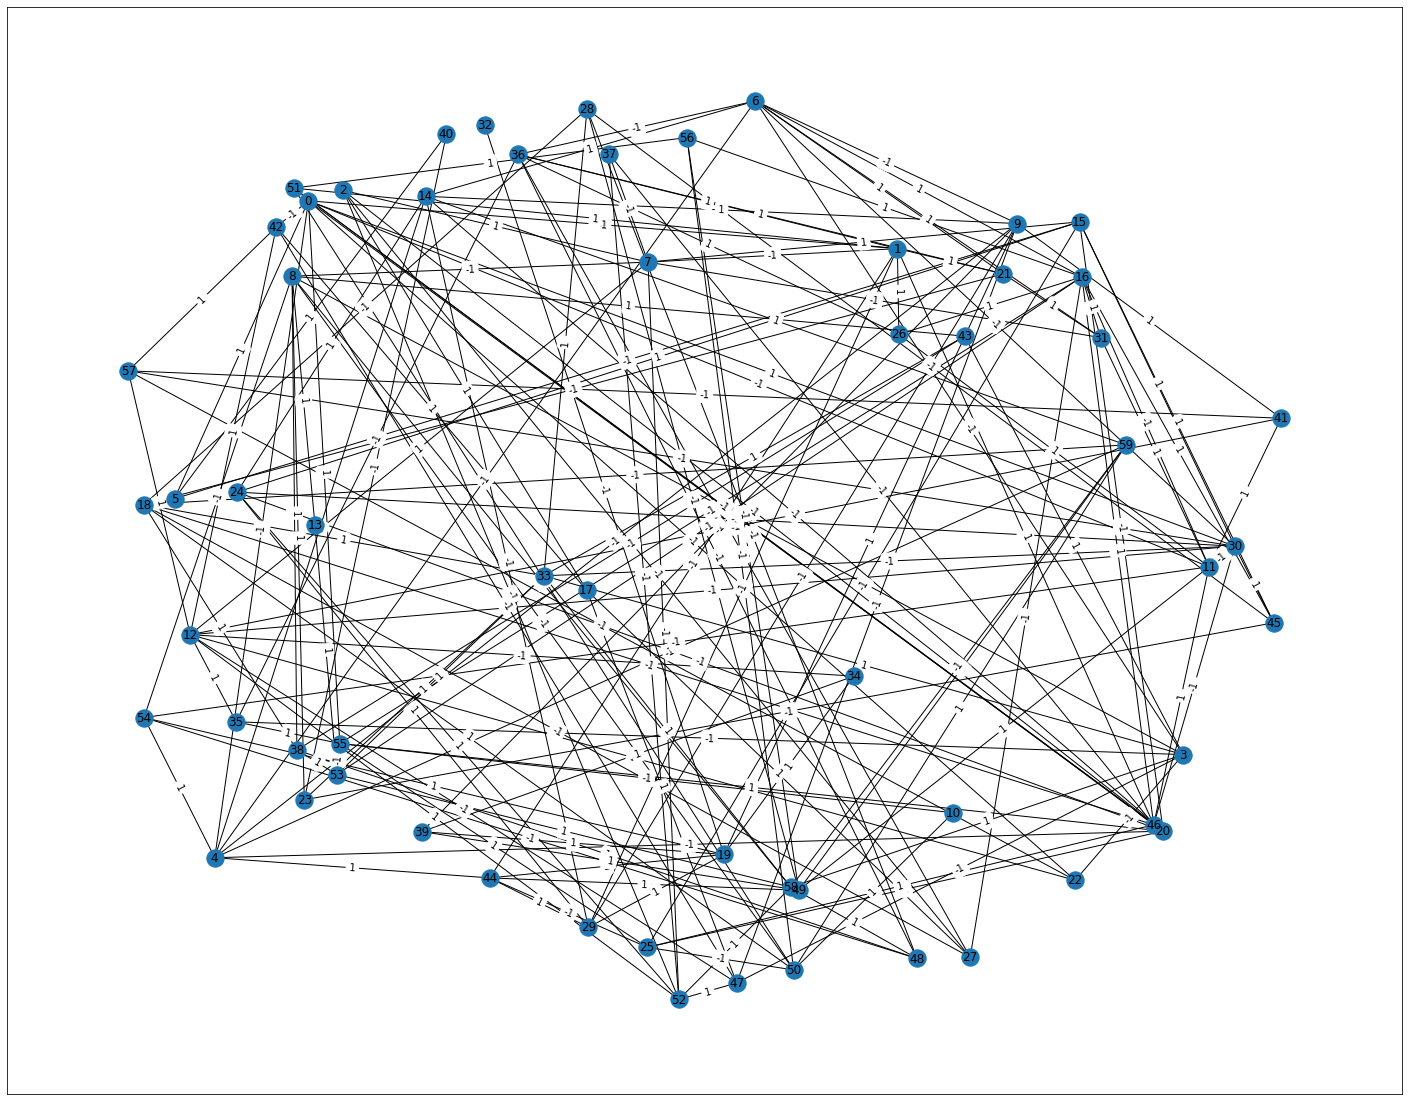

In [318]:
pos = position(G)
plotGraph(G,pos)

In [319]:
EP, EN = edgesEN(G)
HP = nx.Graph()
HN = nx.Graph()

HP.add_nodes_from(G)
HN.add_nodes_from(G)

HP.add_edges_from(EP)
HN.add_edges_from(EN)

print(f"G : #nodes= {G.number_of_nodes()}, #edges = {G.number_of_edges()}")
print(f"HP : #nodes= {HP.number_of_nodes()}, #edges = {HP.number_of_edges()}")
print(f"HN : #nodes= {HN.number_of_nodes()}, #edges = {HN.number_of_edges()}")

G : #nodes= 60, #edges = 178
HP : #nodes= 60, #edges = 93
HN : #nodes= 60, #edges = 85


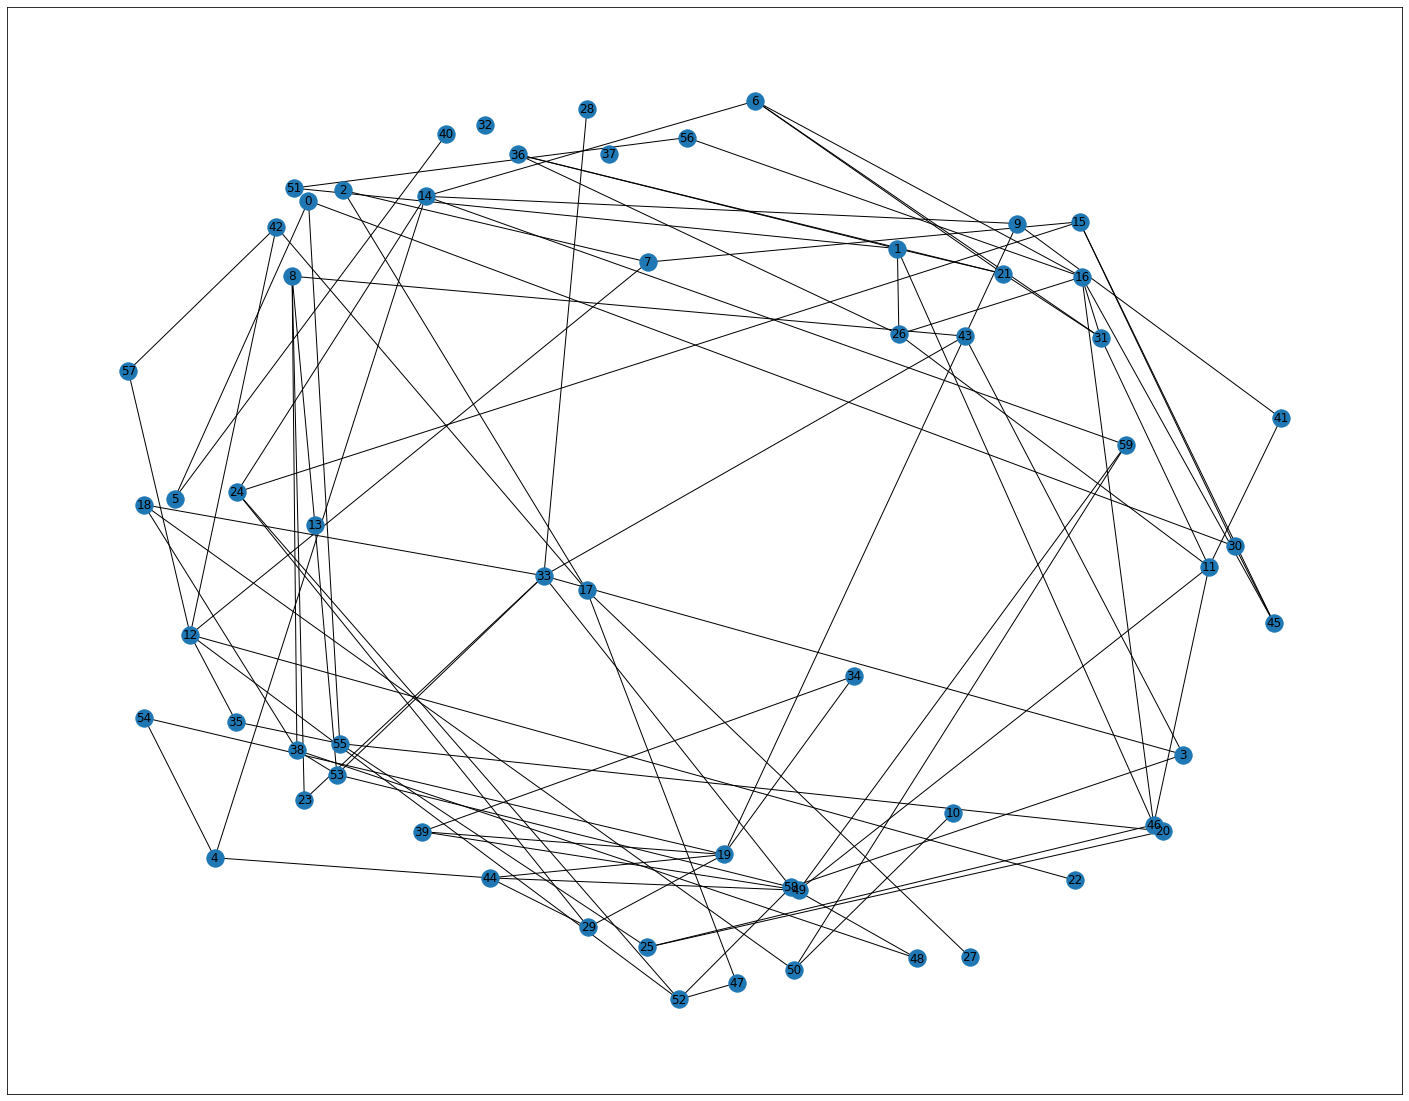

In [320]:
plotGraph(HP, pos)

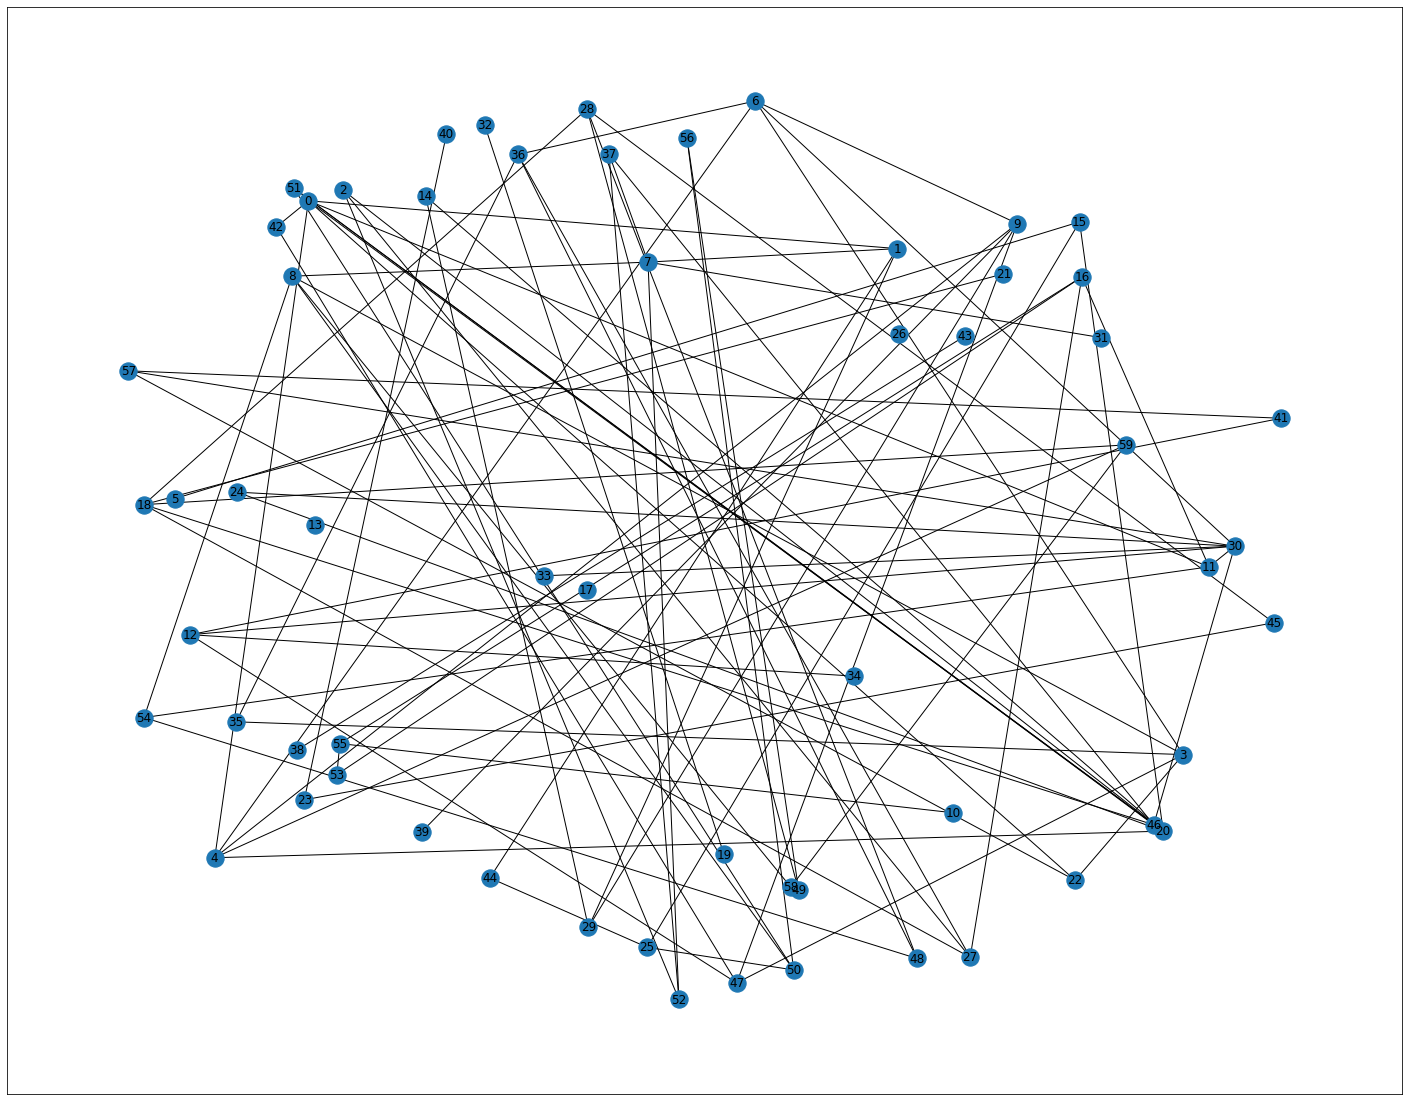

In [321]:
plotGraph(HN,pos)

In [ ]:
VK = setVK(G, k_)
method = "mip"
objval, objbound, mipgap, nodecount, runtime, status, xk, yelim = edge1_formulation(G, k_, VK, EP, EN, method)

print("ub = ", objval)
print("time = ", runtime)
print("status = ", status)
print("lb = ", objbound)
print("gap = ", mipgap)
print("nodes = ", nodecount)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1415 rows, 478 columns and 4365 nonzeros
Model fingerprint: 0xc8a93741
Variable types: 0 continuous, 478 integer (478 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 97.0000000
Presolve time: 0.00s
Presolved: 1415 rows, 478 columns, 4365 nonzeros
Variable types: 0 continuous, 478 integer (478 binary)

Root relaxation: objective 0.000000e+00, 303 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000   

In [323]:
VK = setVK(G, k_)
method = "mip"
objval, objbound, mipgap, nodecount, runtime, status, xk, yelim = edge2_formulation(G, k_, VK, EP, EN, method)

print("ub = ", objval)
print("time = ", runtime)
print("status = ", status)
print("lb = ", objbound)
print("gap = ", mipgap)
print("nodes = ", nodecount)

ub =  26.0
time =  37.388800859451294
status =  1
lb =  26.0
gap =  0.0
nodes =  20821.0


In [ ]:
VK = setVK(G, k_)
method = "mip"
objval, objbound, mipgap, nodecount, runtime, status, xk, yelim = edge3_formulation(G, k_, VK, EP, EN, method)

print("ub = ", objval)
print("time = ", runtime)
print("status = ", status)
print("lb = ", objbound)
print("gap = ", mipgap)
print("nodes = ", nodecount)

ub =  26.0
time =  34.67873978614807
status =  1
lb =  26.0
gap =  0.0
nodes =  20821.0


In [269]:
print(xk)

[(0, 1), (1, 4), (2, 3), (3, 3), (4, 2), (5, 0), (6, 4), (7, 3), (8, 4), (9, 3), (10, 4), (11, 2), (12, 3), (13, 2), (14, 1), (15, 3), (16, 4), (17, 3), (18, 4), (19, 0), (20, 4), (21, 0), (22, 0), (23, 3), (24, 1), (25, 4), (26, 0), (27, 1), (28, 3), (29, 0), (30, 0), (31, 0), (32, 3), (33, 2), (34, 0), (35, 2), (36, 0), (37, 2), (38, 4), (39, 0), (40, 0), (41, 0), (42, 3), (43, 0), (44, 0), (45, 0), (46, 1), (47, 1), (48, 4), (49, 0), (50, 0), (51, 3), (52, 1), (53, 2), (54, 0), (55, 0), (56, 3), (57, 3), (58, 1), (59, 0)]


In [270]:
print(yelim)

[]


In [271]:
for i in range(k_):
    print(f"particao {i}: ", end="")
    for v in xk:
        if v[1] == i:
            print(v[0], end=", ")
    print()

particao 0: 5, 19, 21, 22, 26, 29, 30, 31, 34, 36, 39, 40, 41, 43, 44, 45, 49, 50, 54, 55, 59, 
particao 1: 0, 14, 24, 27, 46, 47, 52, 58, 
particao 2: 4, 11, 13, 33, 35, 37, 53, 
particao 3: 2, 3, 7, 9, 12, 15, 17, 23, 28, 32, 42, 51, 56, 57, 
particao 4: 1, 6, 8, 10, 16, 18, 20, 25, 38, 48, 


In [272]:
partition = []
for i in range(k_):
    a = []
    for v in xk:
        if v[1] == i:
            a.append(v[0])
    partition.append(set(a))
    
partition

[{5,
  19,
  21,
  22,
  26,
  29,
  30,
  31,
  34,
  36,
  39,
  40,
  41,
  43,
  44,
  45,
  49,
  50,
  54,
  55,
  59},
 {0, 14, 24, 27, 46, 47, 52, 58},
 {4, 11, 13, 33, 35, 37, 53},
 {2, 3, 7, 9, 12, 15, 17, 23, 28, 32, 42, 51, 56, 57},
 {1, 6, 8, 10, 16, 18, 20, 25, 38, 48}]

In [273]:
print("Partitions:")
for i in range(k_):
    print(f"i={i}: tam={len(partition[i])}, S[{i}]={partition[i]}")

Partitions:
i=0: tam=21, S[0]={5, 19, 21, 22, 26, 29, 30, 31, 34, 36, 39, 40, 41, 43, 44, 45, 49, 50, 54, 55, 59}
i=1: tam=8, S[1]={0, 14, 46, 47, 52, 24, 58, 27}
i=2: tam=7, S[2]={33, 35, 4, 37, 11, 13, 53}
i=3: tam=14, S[3]={32, 2, 3, 7, 9, 42, 12, 15, 17, 51, 23, 56, 57, 28}
i=4: tam=10, S[4]={1, 6, 38, 8, 10, 16, 48, 18, 20, 25}


In [274]:
nx.community.is_partition(G, partition)

True

In [275]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

for key, value in partition_map.items():
    print(f"{key}: {value}")

5: 0
19: 0
21: 0
22: 0
26: 0
29: 0
30: 0
31: 0
34: 0
36: 0
39: 0
40: 0
41: 0
43: 0
44: 0
45: 0
49: 0
50: 0
54: 0
55: 0
59: 0
0: 1
14: 1
46: 1
47: 1
52: 1
24: 1
58: 1
27: 1
33: 2
35: 2
4: 2
37: 2
11: 2
13: 2
53: 2
32: 3
2: 3
3: 3
7: 3
9: 3
42: 3
12: 3
15: 3
17: 3
51: 3
23: 3
56: 3
57: 3
28: 3
1: 4
6: 4
38: 4
8: 4
10: 4
16: 4
48: 4
18: 4
20: 4
25: 4


In [276]:
color_map = []
for node in G:
    if partition_map[node] == 0:
        color_map.append('gray')
    elif partition_map[node] == 1:
        color_map.append('green')
    else:
        color_map.append('yellow')

#node_colors = [partition_map[n] for n in G.nodes]

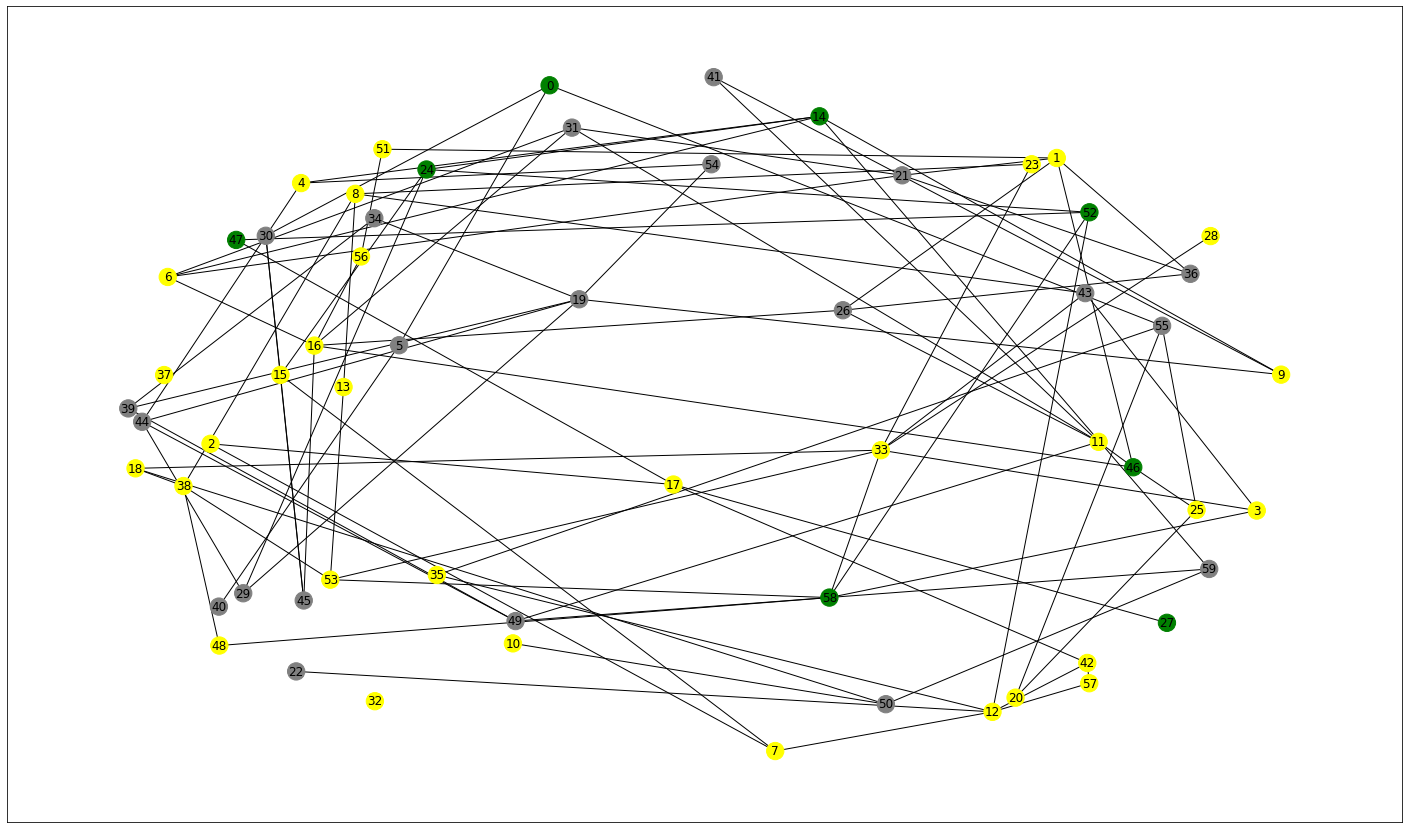

In [277]:
HP.remove_edges_from(yelim)
plt.figure(figsize=(25, 15))        
nx.draw_networkx(HP, pos, node_size=300, node_color=color_map, with_labels=True)
plt.show()

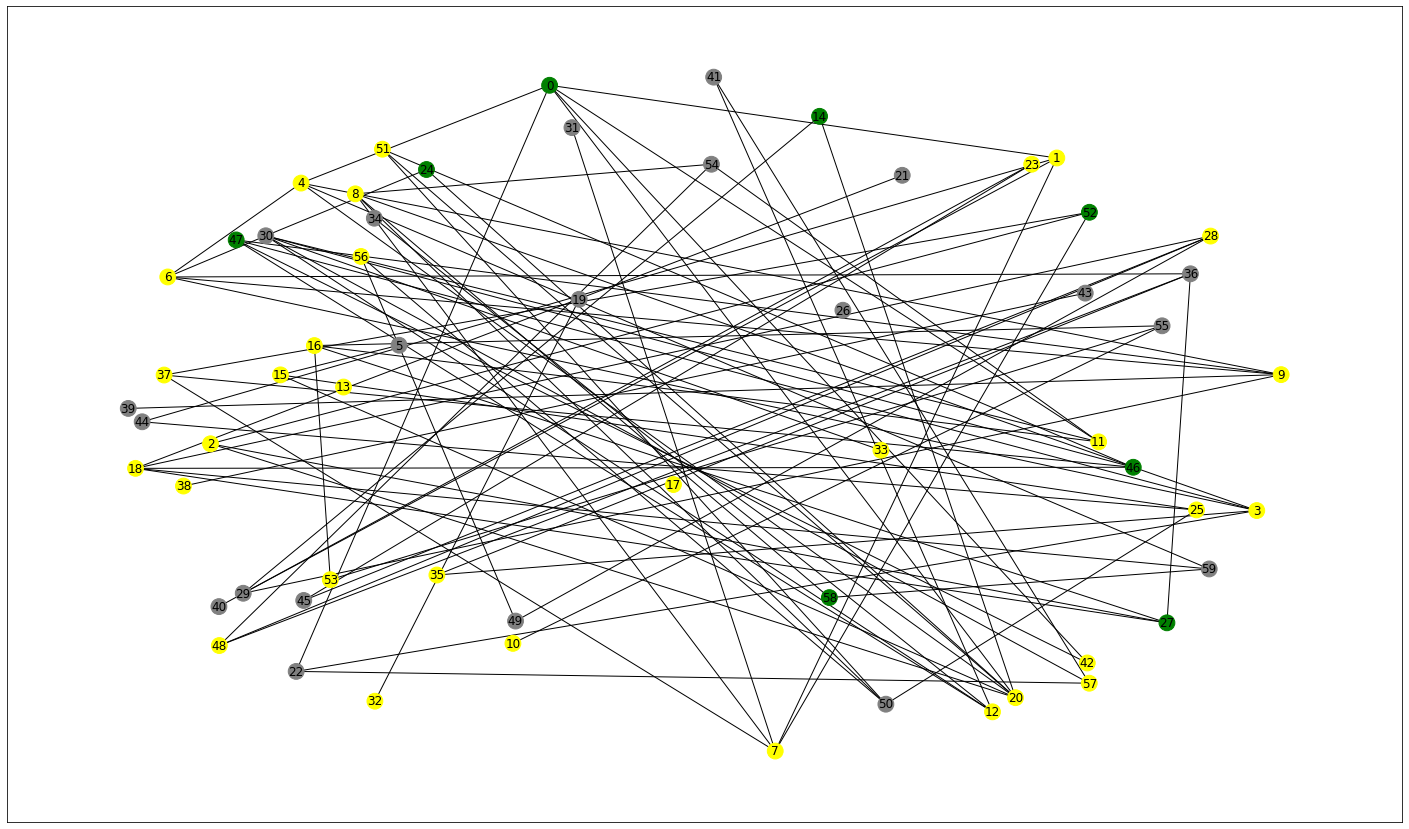

In [278]:
HN.remove_edges_from(yelim)
plt.figure(figsize=(25, 15))        
nx.draw_networkx(HN, pos, node_size=250, node_color=color_map, with_labels=True)
plt.show()

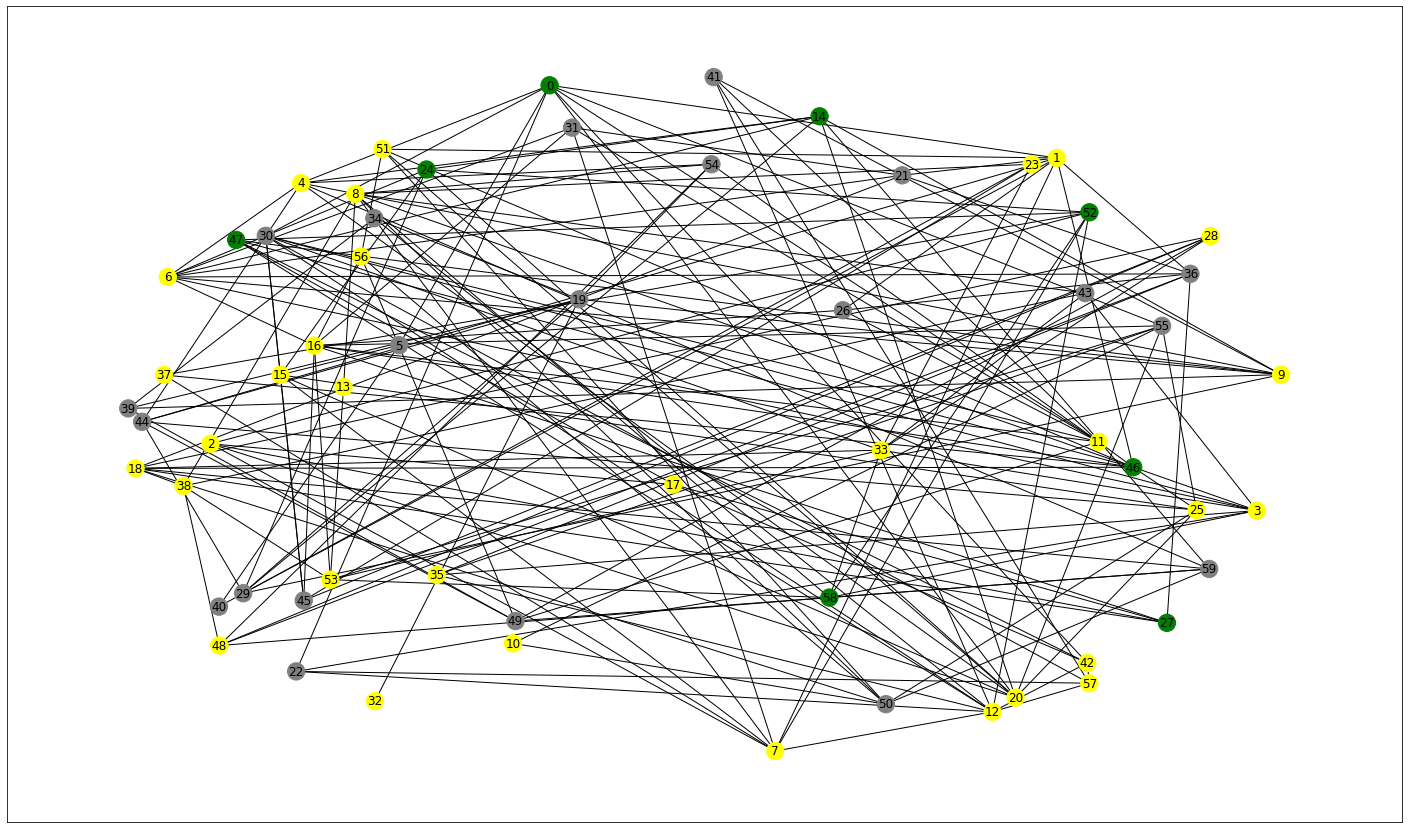

In [279]:
plt.figure(figsize=(25, 15))        
nx.draw_networkx(G, pos, node_size=300, node_color=color_map, with_labels=True)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

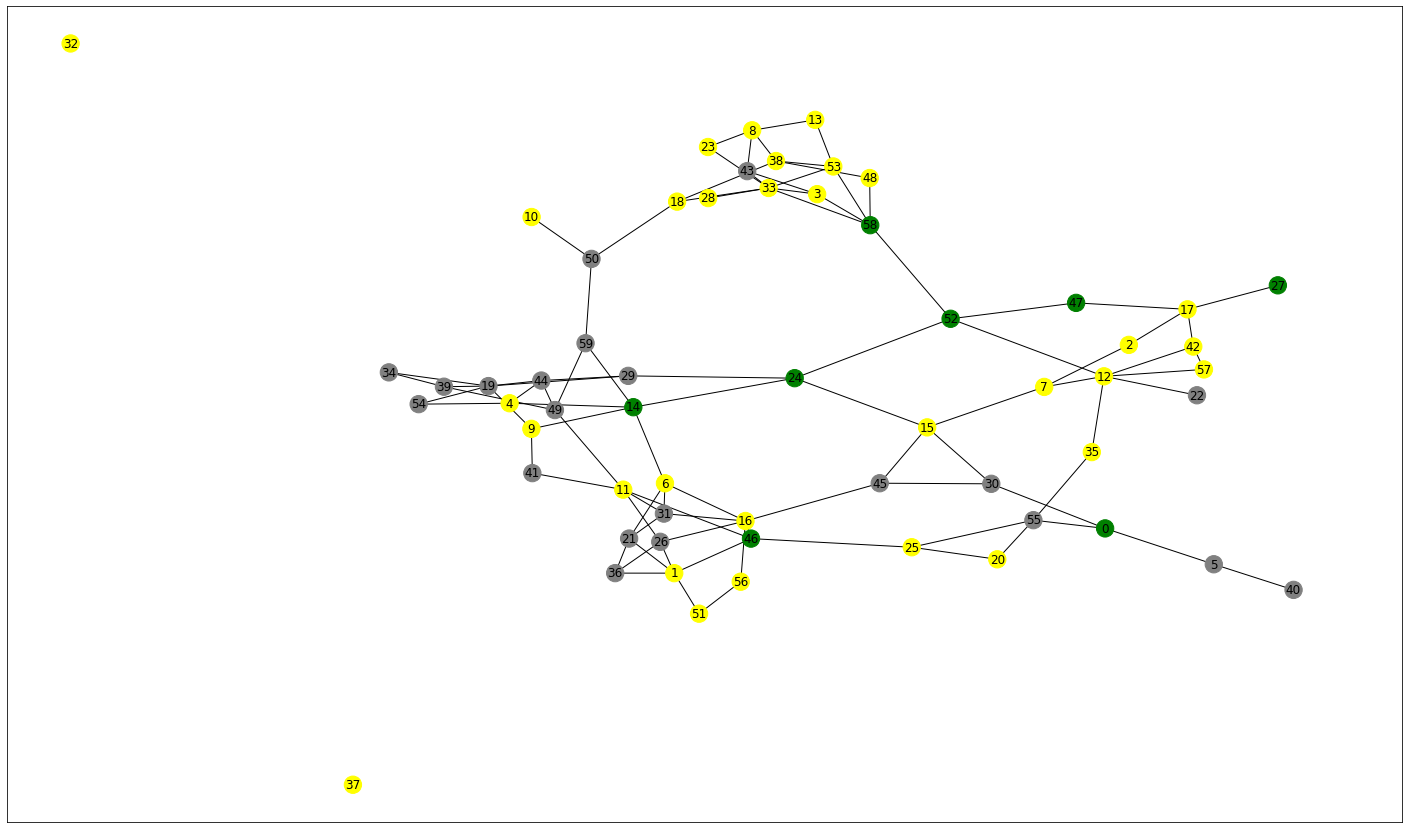

In [280]:
seed = 20532
plt.figure(figsize=(25, 15))        
pos1 = nx.spring_layout(HP, seed=seed)
nx.draw_networkx(HP, pos1, node_size=300, node_color=color_map, with_labels=True)
plt.show()